<div style="background-color: #d8cfc4; padding: 10px;">
    
### Instructions:
1. Review the comments in each code cell and provide the code accordingly. 
2. Run your code in each cell so that the output is visible underneath.
3. Do not create any new cells; place your code in the code cells provided (below the comments).
4. Submit both the Jupyter Notebook file (.ipynb) and a PDF version to Blackboard in one submission.
5. Make sure your PDF shows the output of each code cell before submitting.
6. Missing files may result in a grade penalty.
</div>

In [2]:
# Enter your name here: Hector Paredes
# Enter your Student ID number: G01256501

In [3]:
# Run cell to import libraries 
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily 
import mapclassify 
import folium
import aiohttp
import fsspec

# Load the GeoDataFrame containing United States geometry shapes (at a state-level):
state_shapes = "https://github.com/babdelfa/gis/blob/main/state_geometry.zip?raw=true"
with fsspec.open(state_shapes) as states_file:
    state_shapes = gpd.read_file(states_file)
    
# Load the GeoDataFrame containing United States geometry shapes (at a county-level):
county_shapes = "https://github.com/babdelfa/gis/blob/main/counties_geometry.zip?raw=true"
with fsspec.open(county_shapes) as counties_file:
    county_shapes = gpd.read_file(counties_file)

# Load the DataFrame of COVID-19 daily cumulative data for U.S. counties
df = pd.read_csv("https://raw.githubusercontent.com/babdelfa/project/main/cases21.csv")

### County Level Analysis

In [5]:
"""Problem 1"""
# Identify the top 5 counties with the highest cumulative COVID-19 case counts and display their totals.

#Renaming some of the columns to make it easier to understand.
df.rename(columns = {'Admin2' : 'County', 'Province_State' : 'State', 'Combined_Key' : 'County_State'}, inplace = True)
df.head()

#removing some of the columns 
df.drop(columns=["iso3", "State_Abbr", "County_State", "Lat", "Long_"], inplace= True)  
df.head()

#reshaping the dataframe, so that it is just county, state, date, and cases
df_cases_melted = pd.melt(df, id_vars=["FIPS", 'County', 'State'], var_name="date", value_name="cases") 
df_cases_melted.tail()

df_cases_melted.date = pd.to_datetime(df_cases_melted.date) 
df_cases_melted.tail()

#Grouping the dataframe by county and state. Then summing up the cases. 
df_cases = df_cases_melted.groupby(["FIPS", "County", "State"], as_index = False).cases.sum() 
df_cases.head()

#Finding the top 5 counties with the highest cumulative COVID-19 cases counts.
Top5 = df_cases.sort_values(ascending = False, by = "cases").head(5)
Top5

,FIPS,County,State,cases
206,6037.0,Los Angeles,California,537345697
105,4013.0,Maricopa,Arizona,250139046
612,17031.0,Cook,Illinois,245247178
364,12086.0,Miami-Dade,Florida,229749307
2625,48201.0,Harris,Texas,220574308


In [95]:
"""Problem 2"""
# Write code to determine the 'Day 0' (the first reported COVID-19 case) for each of the top 5 counties with the highest cumulative case counts. 
# Display the results in a clear, readable format with the county name and corresponding 'Day 0' date.

#Created an empty day 0 dictionary. 
day0 = {}
# created a for loop for county in top the Top5 dataframe. 
# Then filtered out the counties from df_cases_melted because that's where the date column is as well
# Then found the earliest date where the cases were above 0 for the counties. 
# Then stored the results inside the day0 dictionary
for county in Top5["County"]:
    counties = df_cases_melted[df_cases_melted["County"] == county]
    day0case = counties[counties["cases"] > 0]["date"].min()
    day0[county] = day0case


# to display the results in a clear format, I turned the dictionary into a data frame. 
day0 = pd.DataFrame(list(day0.items()), columns = ["County", "Day 0"])
day0 

,County,Day 0
0,Los Angeles,2020-01-26
1,Maricopa,2020-01-26
2,Cook,2020-01-24
3,Miami-Dade,2020-03-12
4,Harris,2020-03-05


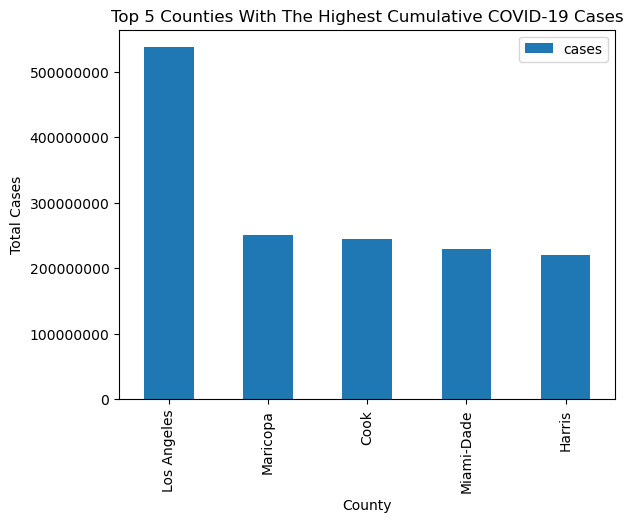

In [69]:
"""Problem 3"""
# Sort the data in descending order and create a bar plot to display the top 5 counties with the highest cumulative COVID-19 cases.
Top5.plot(x = "County", y = "cases", kind = "bar")
plt.ticklabel_format(style = "plain", axis = "y")
plt.title("Top 5 Counties With The Highest Cumulative COVID-19 Cases")
plt.ylabel("Total Cases")
plt.show()

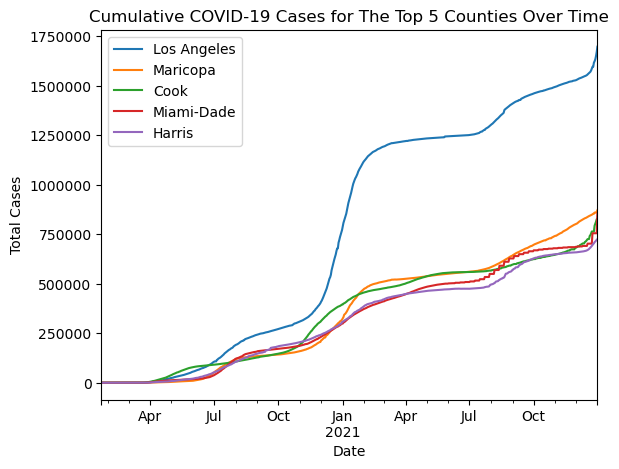

In [67]:
"""Problem 4"""
# Create a line plot to visualize trends in cumulative COVID-19 cases for the top 5 counties over time. 
# Display the cumulative case counts for all five counties on the same chart.

#Filtering each top 5 county from df_cases_melted then grouping by date and then summing up the cases and plotting it.
LA = df_cases_melted[df_cases_melted.County == "Los Angeles"]
LA.groupby(["date"])["cases"].sum().plot(label = "Los Angeles")

Maricopa = df_cases_melted[df_cases_melted.County == "Maricopa"]
Maricopa.groupby(["date"])["cases"].sum().plot(label = "Maricopa")

Cook = df_cases_melted[df_cases_melted.County == "Cook"]
Cook.groupby(["date"])["cases"].sum().plot(label = "Cook")

Miami = df_cases_melted[df_cases_melted.County == "Miami-Dade"]
Miami.groupby(["date"])["cases"].sum().plot(label = "Miami-Dade")

Harris = df_cases_melted[df_cases_melted.County == "Harris"]
Harris.groupby(["date"])["cases"].sum().plot(label = "Harris")
plt.ticklabel_format(style = "plain", axis = "y")
plt.legend()
plt.title("Cumulative COVID-19 Cases for The Top 5 Counties Over Time")
plt.ylabel("Total Cases")
plt.xlabel("Date")
plt.show()

In [101]:
"""Problem 5"""
# Create an interactive choropleth map highlighting the top 5 counties with the highest cumulative COVID-19 case counts.
# Configure popups to display each county's name, state, and cumulative case count (nothing else).
# Limit popups on the map to these top five counties.

#Merging Top5 with county_shapes on FIPS
gdf= pd.merge(Top5, county_shapes, left_on = ["FIPS"], right_on = ["FIPS_BEA"])
gdf

#Merging gdf (created above) with state_shapes on state
gdf2 = pd.merge(gdf, state_shapes, left_on = ["State"], right_on = ["STATE_NAME"])
gdf2

gdf2.rename(columns = {"cases" : "Total Cases"}, inplace = True)

#Creating the choroleth map
gdf3 = gdf2[["County", "State", "Total Cases", "geometry_x"]]
gdf3 = gpd.GeoDataFrame(gdf3, geometry= "geometry_x")
gdf3.explore(column = "Total Cases", cmap = "Set2", legend = True, scheme = "EqualInterval")

### State Level Analysis

In [11]:
"""Problem 6"""
# Identify the top 5 states with the highest cumulative COVID-19 case counts and display their totals.

#Grouping by state and summing up the cases. 
df_cases_states = df_cases_melted.groupby(["State"], as_index = False).cases.sum() 
df_cases_states.head()

#Finding top 5 states
Top5_states = df_cases_states.sort_values(ascending = False, by = "cases").head(5)
Top5_states

,State,cases
4,California,1685603009
43,Texas,1367108959
9,Florida,1118731086
32,New York,902562294
13,Illinois,608329638


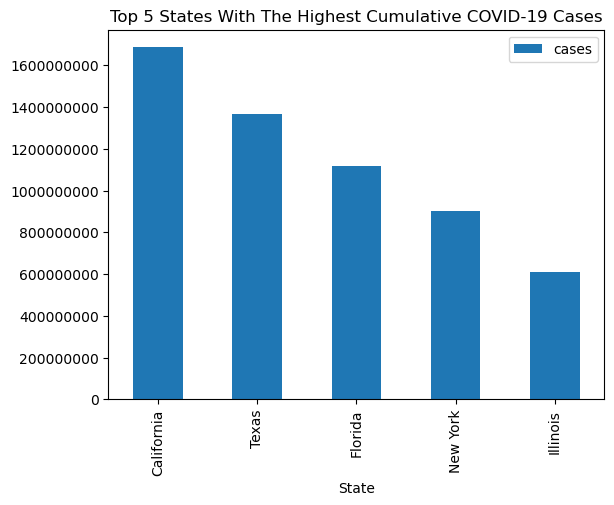

In [61]:
"""Problem 7"""
# Sort the data in descending order and create a bar plot to display the top 5 states with the highest cumulative COVID-19 cases.

Top5_states.plot(x = "State", y = "cases", kind = "bar")
plt.ticklabel_format(style = "plain", axis = "y")
plt.title("Top 5 States With The Highest Cumulative COVID-19 Cases")
plt.show()

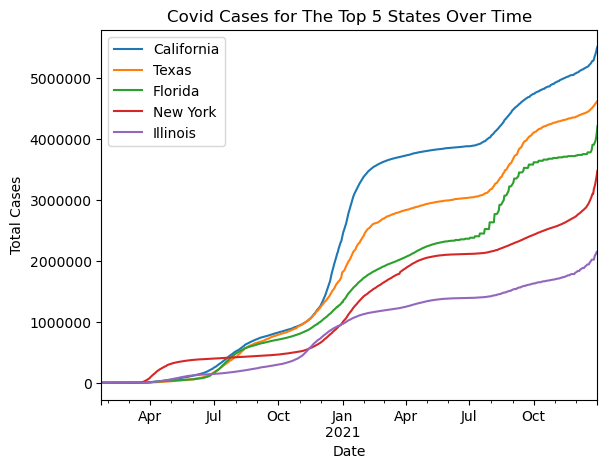

In [71]:
"""Problem 8"""
# Create a line plot to visualize trends in cumulative COVID-19 cases for the top 5 states over time. 
# Display the cumulative case counts for all five states on the same chart.

#Filtering each top 5 state then grouping by date and then summing up the cases and plotting it.
California = df_cases_melted[df_cases_melted.State == "California"]
California.groupby(["date"])["cases"].sum().plot(label = "California")

Texas = df_cases_melted[df_cases_melted.State == "Texas"]
Texas.groupby(["date"])["cases"].sum().plot(label = "Texas")

Florida = df_cases_melted[df_cases_melted.State == "Florida"]
Florida.groupby(["date"])["cases"].sum().plot(label = "Florida")

NewYork = df_cases_melted[df_cases_melted.State == "New York"]
NewYork.groupby(["date"])["cases"].sum().plot(label = "New York")

Illinois = df_cases_melted[df_cases_melted.State == "Illinois"]
Illinois.groupby(["date"])["cases"].sum().plot(label = "Illinois")
plt.ticklabel_format(style = "plain", axis = "y")
plt.legend()
plt.title("Covid Cases for The Top 5 States Over Time")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.show()


In [14]:
"""Problem 9"""
# Create an interactive choropleth map highlighting the top 5 states with the highest cumulative COVID-19 case counts.
# Configure popups to display each state's name and cumulative case count (nothing else).
# Limit popups on the map to these top five states.

#Merging top_5_states with state_shapes on state
gdfs = pd.merge(Top5_states, state_shapes, left_on = ["State"], right_on = ["STATE_NAME"])
gdfs

gdfs.rename(columns = {"cases" : "Total Cases"}, inplace = True)

#creating the choropleth map
gdfs1 = gdfs[["State", "Total Cases", "geometry"]]
gdfs1 = gpd.GeoDataFrame(gdfs1, geometry= "geometry")
gdfs1.explore(column = "Total Cases", cmap = "Set2", legend = True, scheme = "EqualInterval")

### County and State Subplots

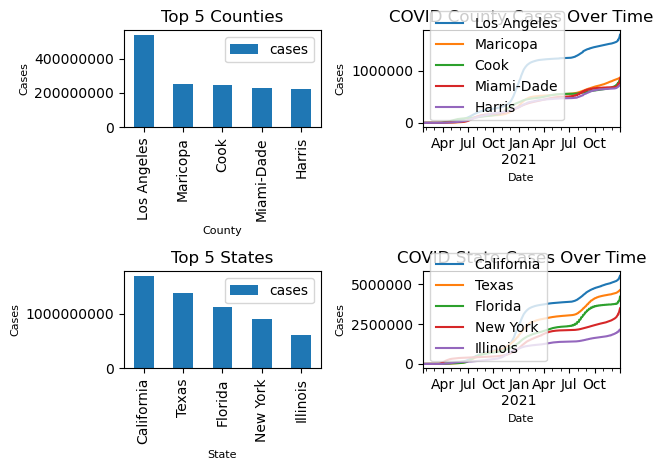

In [87]:
"""Problem 10"""
# Create a 2x2 grid of subplots and include the two line plots and two bar plots from above.

#Creating a subplot with 2 rows and 2 columns and then repeating the process of the two line plots and two bar plots from above. 
fig, axes = plt.subplots(nrows = 2, ncols = 2)
Top5.plot(x = "County", y = "cases", kind = "bar", ax = axes[0,0])
axes[0,0].set_title("Top 5 Counties")
axes[0,0].set_xlabel("County", fontsize = 8)
axes[0,0].set_ylabel("Cases", fontsize = 8)
LA.groupby(["date"])["cases"].sum().plot(label = "Los Angeles", ax = axes[0,1])
Maricopa.groupby(["date"])["cases"].sum().plot(label = "Maricopa", ax = axes[0,1])
Cook.groupby(["date"])["cases"].sum().plot(label = "Cook", ax = axes[0,1])
Miami.groupby(["date"])["cases"].sum().plot(label = "Miami-Dade", ax = axes[0,1])
Harris.groupby(["date"])["cases"].sum().plot(label = "Harris", ax = axes[0,1])
axes[0,1].legend()
axes[0,1].set_title("COVID County Cases Over Time")
axes[0,1].set_xlabel("Date", fontsize = 8)
axes[0,1].set_ylabel("Cases", fontsize = 8)
Top5_states.plot(x = "State", y = "cases", kind = "bar", ax = axes[1,0])
axes[1,0].set_title("Top 5 States")
axes[1,0].set_xlabel("State", fontsize = 8)
axes[1,0].set_ylabel("Cases", fontsize = 8)
California.groupby(["date"])["cases"].sum().plot(label = "California", ax = axes[1,1])
Texas.groupby(["date"])["cases"].sum().plot(label = "Texas", ax = axes[1,1])
Florida.groupby(["date"])["cases"].sum().plot(label = "Florida", ax = axes[1,1])
NewYork.groupby(["date"])["cases"].sum().plot(label = "New York", ax = axes[1,1])
Illinois.groupby(["date"])["cases"].sum().plot(label = "Illinois", ax = axes[1,1])
axes[1,1].set_title("COVID State Cases Over Time")
axes[1,1].set_xlabel("Date", fontsize = 8)
axes[1,1].set_ylabel("Cases", fontsize = 8)
axes[1,1].legend()
axes[0,0].ticklabel_format(style = "plain", axis = "y")
axes[1,0].ticklabel_format(style = "plain", axis = "y")
axes[1,1].ticklabel_format(style = "plain", axis = "y")
axes[0,1].ticklabel_format(style = "plain", axis = "y")
plt.tight_layout()

plt.show()